# I. Algorithm

In [47]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# II. Application to Data Set

Once again, I'll load in the data and do some cleaning. We are trying to predict roller coasters as inverted or non-inverted based on features such as height, speed, and Gforce.

In [4]:
coaster_data = pd.read_csv("../coaster_db.csv")

coaster_subset = coaster_data[['height_ft','speed_mph','Gforce_clean','Inversions_clean']]

clean_data = coaster_subset.dropna()

# Creating column for whether coaster has at least one inversion or not

clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)

print(f"There are {clean_data.shape[0]} roller coasters we have data for.")
print(f"There are {np.sum(clean_data['Inverted'])} inverted roller coasters.")
print(f"There are {clean_data.shape[0]-np.sum(clean_data['Inverted'])} non-inverted roller coasters.")


There are 70 roller coasters we have data for.
There are 36 inverted roller coasters.
There are 34 non-inverted roller coasters.


/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_6543/1753589870.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)


Now, I'll summarize the previous results.

From using **kNN**, we got 78% accuracy with Manhattan distance where we only used height and speed.
From using **Decision Trees**, we got 85.7% accuracy where we used height, speed, and G-force.


In [39]:

# Features and target
X = clean_data[['height_ft', 'speed_mph', 'Gforce_clean']]
y = clean_data['Inverted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create knn and decision tree models

knn = KNeighborsClassifier(n_neighbors=15)
dtree = DecisionTreeClassifier(random_state=12)

# Using bagging for kNN and decision tree

bagged_knn = BaggingClassifier(estimator=knn, n_estimators=10, random_state=12)
bagged_dtree = BaggingClassifier(estimator=dtree, n_estimators=10, random_state=12)

bagged_knn.fit(X_train, y_train)
bagged_dtree.fit(X_train, y_train)

# Creating ensemble method by combining knn and decision tree results
voting_ensemble = VotingClassifier(
    estimators=[('bag_knn', bagged_knn), ('bag_tree', bagged_dtree)],
    voting='soft'  
)

voting_ensemble.fit(X_train, y_train)

# Diagnosing Model

y_pred = voting_ensemble.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred),3)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.929
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.90      1.00      0.95         9

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14



We can see how the accuracy has increased to 93%, with improvements to recall and precision as well.

Now, let's evaluate how changing the number of individual models used in the bagging process affects the accuracy.

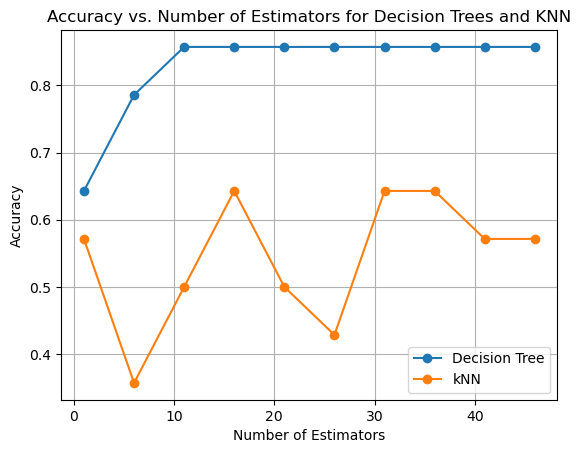

In [46]:
n_estimators_list = list(range(1, 51, 5))
tree_accuracies = []
knn_accuracies = []

# Plotting accuracy for number of individual models are used
for n in n_estimators_list:
    bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n, random_state=42)
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    tree_accuracies.append(acc)

    bag = BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=n, random_state=42)
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    knn_accuracies.append(acc)

plt.plot(n_estimators_list, tree_accuracies, marker='o', label = 'Decision Tree')
plt.plot(n_estimators_list, knn_accuracies, marker='o', label = 'kNN')
plt.title('Accuracy vs. Number of Estimators for Decision Trees and KNN')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

For Decision Trees, we can see an increasing function. As the number of estimators increases, the accuracy increases and eventually flattens once you hit 12 estimators. For kNN, we see a different trend. The accuracy fluctuates depending on the number of esimators with peaks around 16 and between 30-40.

Now, we will try boosting.

In [62]:

# Create boosting models

# AdaBoost with shallow decision trees
ada_dtree = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  
    n_estimators=12,
    learning_rate=0.3,
    random_state=150
)

# Gradient Boosting
grad_boost = GradientBoostingClassifier(
    n_estimators=12,
    learning_rate=0.1,
    max_depth=5,
    random_state=150
)

# Fit individual models 
ada_dtree.fit(X_train, y_train)
grad_boost.fit(X_train, y_train)

# Ensemble using soft voting
boosting_ensemble = VotingClassifier(
    estimators=[('ada', ada_dtree), ('grad', grad_boost)],
    voting='soft'  # or 'hard'
)

boosting_ensemble.fit(X_train, y_train)

# Diagnosing Model
y_pred = boosting_ensemble.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.786
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.75      1.00      0.86         9

    accuracy                           0.79        14
   macro avg       0.88      0.70      0.71        14
weighted avg       0.84      0.79      0.76        14



Interesting that the precision is 100% for non-inverted roller coasters and the recall is 100% for inverted roller coasters. However, the recall for non-inverted roller coasters is very low, so the boosting algorithm is favoring the predictions of roller coasters as inverted.